In [ ]:
#Geometric Brownian Motion

## Importación de librerías y datos
---

In [1]:
import numpy as np
import pandas as pd

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt

#### Ahora definimos los tickers con activos de nuestra watchlist

In [3]:
tickers=['AAPL','MSFT','NVDA','AMZN','GOOGL']

In [4]:
data=yf.download(tickers,period='3y',progress=False,auto_adjust=False)

In [16]:
data.head()

Price        Adj Close                                               \
Ticker            AAPL       AMZN      GOOGL        MSFT       NVDA   
Date                                                                  
2023-01-17  133.919662  96.050003  90.605423  234.737656  17.684296   
2023-01-18  133.200531  95.459999  90.436691  230.303696  17.359625   
2023-01-19  133.259613  93.680000  92.352219  226.514282  16.748234   
2023-01-20  135.820969  97.250000  97.284935  234.610687  17.821161   
2023-01-23  139.012817  97.519997  99.041672  236.915604  19.173805   

Price            Close                                               ...  \
Ticker            AAPL       AMZN      GOOGL        MSFT       NVDA  ...   
Date                                                                 ...   
2023-01-17  135.940002  96.050003  91.290001  240.350006  17.702000  ...   
2023-01-18  135.210007  95.459999  91.120003  235.809998  17.377001  ...   
2023-01-19  135.270004  93.680000  93.050003  231.929993  16.764999  ...   
2023-01-20  137.869995  97.250000  98.019997  240.220001  17.839001  ...   
2023-01-23  141.110001  97.519997  99.790001  242.580002  19.193001  ...   

Price             Open                                                 Volume  \
Ticker            AAPL       AMZN      GOOGL        MSFT       NVDA      AAPL   
Date                                                                            
2023-01-17  134.830002  98.680000  92.059998  237.970001  16.899000  63646600   
2023-01-18  136.820007  97.250000  92.139999  241.570007  17.667000  69672800   
2023-01-19  134.080002  94.739998  90.720001  233.779999  17.035999  58280400   
2023-01-20  135.279999  93.860001  95.099998  234.860001  17.011000  80223600   
2023-01-23  138.119995  97.559998  97.949997  241.100006  18.063999  81760300   

Price                                                
Ticker          AMZN     GOOGL      MSFT       NVDA  
Date                                                 
2023-01-17  72755000  32602400  29831300  511102000  
2023-01-18  79570400  29116700  30028700  439624000  
2023-01-19  69002700  37000400  28623000  452932000  
2023-01-20  67481500  63191100  35389800  564967000  
2023-01-23  76501100  40005100  31934000  655163000  

[5 rows x 30 columns]

In [5]:
if isinstance(data.columns, pd.MultiIndex):
   df = data['Adj Close'].dropna(how='any')
else:
   if set(tickers).issubset(data.columns):
       df = data[tickers].dropna(how='any')
   elif 'Close' in data.columns:
       df = data['Close'].dropna(how='any')
   else:
       raise RuntimeError("Unexpected yf.download format; inspect 'data.columns'")
logr = np.log(df).diff().dropna()
SO = df.iloc[-1].values.astype(float)  #

#### Cálculo de Retornos y Parámetros (Drift y Volatilidad)
---
Calculamos los retornos logarítmicos. Aquí definimos mu (tendencia) y sigma (matriz de covarianza). Multiplicar por 252 es el estándar para anualizar los datos, asumiendo los días hábiles de la bolsa

In [6]:
T,steps,paths,seed=1.0,252,5000,123
dt=T/steps

In [7]:
mu=(logr.mean().values/dt)+0.5*(logr.std(ddof=1).values * np.sqrt(252))**2
sigma=logr.cov().values*252 #covarianza anual

#### Descomposición de Cholesky
---
Este es el paso crítico. Usamos np.linalg.cholesky. Esto descompone la matriz de covarianza para que los números aleatorios que generamos (Z) mantengan la correlación histórica entre las acciones. Si una cae, el modelo sabe que las otras tienden a seguirla.

In [8]:
rng=np.random.default_rng(seed)
L=np.linalg.cholesky(sigma*dt)
Z=rng.standard_normal((steps,paths,len(SO)))
ZF=Z.reshape(steps*paths,len(SO))@L.T
corr=ZF.reshape(steps,paths,len(SO))

#### Generación de Trayectorias (Simulación Estocástica)
---
Aplicamos la fórmula del Movimiento Browniano Geométrico. Usamos np.cumsum sobre los incrementos logarítmicos para construir el camino del precio día a día de forma eficiente y vectorizada

In [9]:
drift=(mu-0.5 * np.diag(sigma))*dt
inc=drift[None,None,:]+corr           #per step log-inc
logp=np.vstack([np.zeros((1,paths,len(SO))),np.cumsum(inc,axis=0)])

In [10]:
assets=SO[None,None,:]*np.exp(logp)

In [11]:
w=np.repeat(1/len(SO),len(SO))
#(steps+1,paths)
portafolio=(assets*w.reshape(1,1,-1)).sum(axis=2)

#### Estadísticos de Riesgo (VaR y Mediana)
---
Calculamos los percentiles 5, 50 y 95. El percentil 5 es nuestro Value at Risk (VaR): nos indica el peor escenario probable con un 95% de confianza, fundamental para la gestión de riesgo profesional.

In [12]:
ST=portafolio[-1]
p5,p50,p95=np.percentile(ST,[5,50,95])
print(f"Start: {np.sum(SO*w):.2f} | 5%={p5:.2f} median={p50:.2f} 95%={p95:.2f}")

Start: 294.99 | 5%=294.83 median=439.80 95%=666.46


#### Visualización

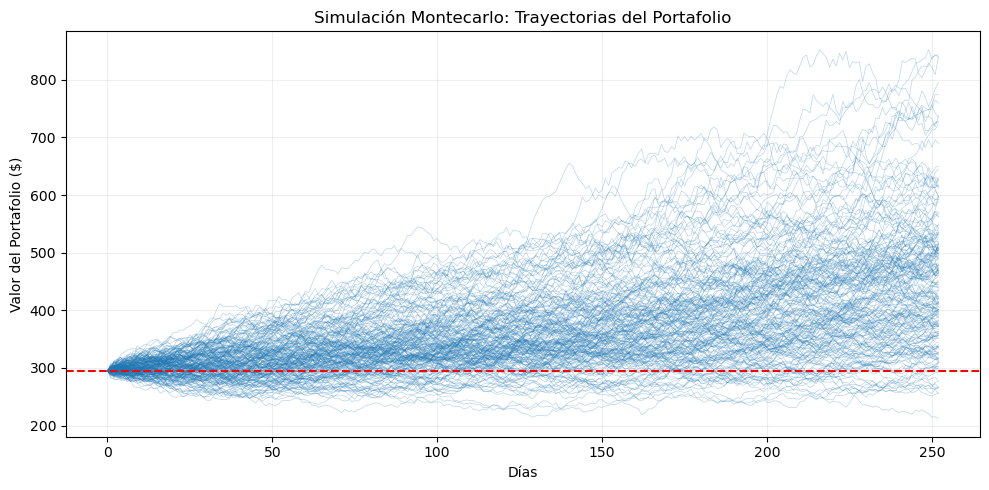

In [13]:
plt.figure(figsize=(10, 5))
#  Seleccionamos los índices de los caminos (no los valores)
indices_muestra = rng.choice(range(paths), size=min(200, paths), replace=False)
for i in indices_muestra:
    # Graficamos todas las filas del camino 'i'
    # Usamos portafolio[:, i] para extraer la columna completa del camino
    plt.plot(portafolio[:, i], color='tab:blue', alpha=0.3, linewidth=0.5)
# 3. Línea base (Valor inicial del portafolio)
plt.axhline(np.sum(SO * w), color='red', linestyle='--', label='Valor Inicial')
plt.title('Simulación Montecarlo: Trayectorias del Portafolio')
plt.xlabel('Días')
plt.ylabel('Valor del Portafolio ($)')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

Para evitar saturar la memoria y el procesador, usamos rng.choice para graficar solo una muestra representativa de 200 caminos. Usamos un alpha bajo para visualizar la densidad de probabilidad (donde se ven más líneas, es donde es más probable que termine el precio).